<a href="https://colab.research.google.com/github/AntoineGilsonGH/Statistical-Assessment-of-Trained-Models/blob/main/Statistical_Assessment_Two_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of statistical performance between two classifiers

little brother of the Statistticla Assessment of two models notebook

### Comparison of two models

It's a **paired test** between the two models


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import uniform, norm, skew, kurtosis
import json
import math
import re
import seaborn as sns
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import ttest_rel

tool functions, used later

In [ ]:
def extract_bounds(intervals):
        if isinstance(intervals, pd.Interval):
            return [intervals.left], [intervals.right]
        elif all(isinstance(interval, pd.Interval) for interval in intervals):
            lower_bounds = [interval.left for interval in intervals]
            upper_bounds = [interval.right for interval in intervals]
            return lower_bounds, upper_bounds
        else:
            raise TypeError("All elements must be pandas Interval objects or a single Interval object")


def extract_info(filename):
    # Use regular expression to find the pattern for model, metric, and additional info
    match = re.search(r'_(.*?)_(.*?)_(.*?)\.csv', filename)
    if match:
        return match.group(1), match.group(2), match.group(3)
    else:
        return None, None, None

# Select your two files containing the errors, with the same metric, of two models or two samples

In [ ]:
filename_1 = "Errors_XGB_onezero_SK_30.csv"
errors_file_1 = pd.read_csv(drive_path_error_1)
errors_1 = errors_file_1.values.flatten()


model_1, metric_1, additional_1 = extract_info(filename_1)
print(f"The first model name is: {model_1}")
print(f"The first metric is: {metric_1}")
print(f"The first additional info is: {additional_1}")

filename_2 = "Errors_DecisionTree_onezero_SK_30.csv"
errors_file_2 = pd.read_csv(drive_path_error_2)
errors_2 = errors_file_2.values.flatten()


model_2, metric_2, additional_2 = extract_info(filename_2)
print(f"The second model name is: {model_2}")
print(f"The second metric is: {metric_2}")
print(f"The second additional info is: {additional_2}")

errors = errors_1 - errors_2 #  for instance : if a value error is negative, the model B less performant

model = f"{model_1}_vs_{model_2}"
metric = f"{metric_1}_vs_{metric_2}"
additional = f"{additional_1}_{additional_2}"

print(f"The model name is: {model}")
print(f"The metric is: {metric}")
print(f"The additional info is: {additional}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The first model name is: XGB
The first metric is: onezero
The first additional info is: SK_30
The second model name is: DecisionTree
The second metric is: onezero
The second additional info is: SK_30
The model name is: XGB_vs_DecisionTree
The metric is: onezero_vs_onezero
The additional info is: SK_30_SK_30


# First feature - ROC AUC Curve of your two classifiers

### According to the data you have you might not have enough data to use this function

Indeed, in order to use this feature, you need **the probability of belonging to a class** (and not the class predicted by your model), and also **the ground truth values of your test set**.

This function might be not efficient and be optimized to have the same results with less data

Empirical AUC of XGB: 0.9845080340567185
Empirical AUC of DecisionTree: 0.9743934447218487


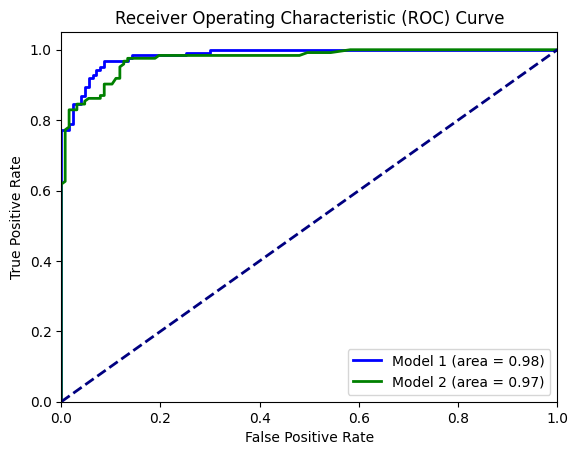

Bootstrapped AUC for XGB: 0.9841892568447187
Bootstrapped AUC for DecisionTree: 0.973688948880812
Percentile Bootstrapped AUC for XGB 95% CI: [0.9727286539745547, 0.9934719288137763]
Percentile Bootstrapped AUC for DecisionTree 95% CI: [0.9563063566432624, 0.9883862965074472]
Basic Bootstrapped AUC for XGB: 95% CI: [0.9749065848756611, 0.9956498597148827]
Basic Bootstrapped AUC for DecisionTree: 95% CI: [0.9589916012541768, 0.9910715411183617]


In [ ]:
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.utils import resample

filename_test = "Values_test_set.csv" # to replace according to your needs
filename_1_proba = "Values_XGB_proba_.csv"
filename_2_proba = "Values_RandomForest_proba_.csv"

errors_test = pd.read_csv(drive_path_test)
y_test = errors_test.values.flatten()

errors_proba_1 = pd.read_csv(drive_path_proba_1)
y_pred_1 = errors_proba_1.values.flatten()

errors_proba_2 = pd.read_csv(drive_path_proba_2)
y_pred_2 = errors_proba_2.values.flatten()


def confidence_intervals_AUC():


    empirical_auc1 = roc_auc_score(y_test, y_pred_1)
    empirical_auc2 = roc_auc_score(y_test, y_pred_2)


    print(f'Empirical AUC of {model_1}: {empirical_auc1}')
    print(f'Empirical AUC of {model_2}: {empirical_auc2}')


    aucs_1 = []
    aucs_2 = []

    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_1)
    fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_2)

    plt.figure()
    plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'Model 1 (area = {empirical_auc1:.2f})')
    plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Model 2 (area = {empirical_auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    n_bootstraps = 1000

    for i in range(n_bootstraps):
        indices = resample(np.arange(len(y_test)), random_state=i)
        if len(np.unique(y_test[indices])) < 2:  # Pour éviter les erreurs de calcul de l'AUC avec des classes uniques
            continue
        auc_1 = roc_auc_score(y_test[indices], y_pred_1[indices])
        auc_2 = roc_auc_score(y_test[indices], y_pred_2[indices])
        aucs_1.append(auc_1)
        aucs_2.append(auc_2)

    alpha = 0.05

    auc_1_lower = np.percentile(aucs_1, 2.5)
    auc_1_upper = np.percentile(aucs_1, 97.5)
    auc_2_lower = np.percentile(aucs_2, 2.5)
    auc_2_upper = np.percentile(aucs_2, 97.5)

    print(f"Bootstrapped AUC for {model_1}: {np.mean(aucs_1)}")
    print(f"Bootstrapped AUC for {model_2}: {np.mean(aucs_2)}")

    print(f"Percentile Bootstrapped AUC for {model_1} 95% CI: [{auc_1_lower}, {auc_1_upper}]")
    print(f"Percentile Bootstrapped AUC for {model_2} 95% CI: [{auc_2_lower}, {auc_2_upper}]")

    print(f"Basic Bootstrapped AUC for {model_1}: 95% CI: [{2*np.mean(aucs_1)-auc_1_upper}, {2*np.mean(aucs_1)-auc_1_lower}]")
    print(f"Basic Bootstrapped AUC for {model_2}: 95% CI: [{2*np.mean(aucs_2)-auc_2_upper}, {2*np.mean(aucs_2)-auc_2_lower}]")

confidence_intervals_AUC()

### Using a library

The paired sample t-test (ttest_rel in scipy.stats) is a statistical method used to compare the means of two related datasets.

In [ ]:
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(errors_1, errors_2)
print("The t_stat is :", t_stat)
print("The p-value is :", p_value)

The t_stat is : 1.0000000000000002
The p-value is : 0.3179165706461152


If you need to pick up your data contained in an excel

## I - We first compute various descriptive statistics and confidence interval on the mean of the difference $D = A - B$

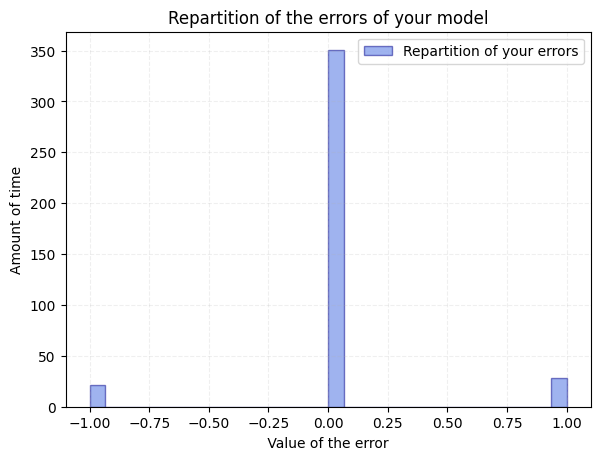

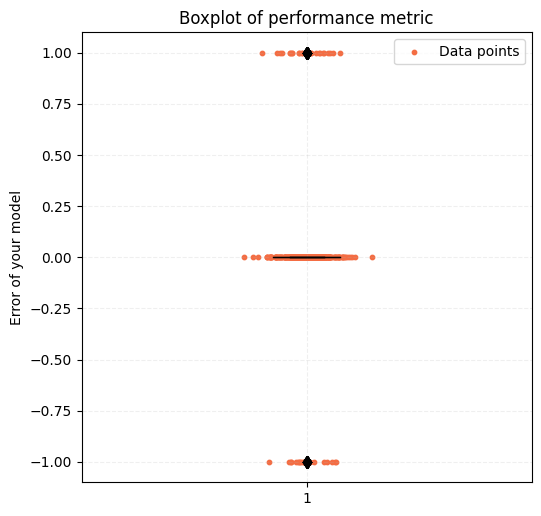

In [ ]:
def hist_errors():

          fig = plt.figure(figsize=(7,5))
          ax = fig.add_axes([0.15,0.15,0.75,0.75])

          plt.title("Repartition of the errors of your model")
          plt.hist(errors, bins=30, label=f"Repartition of your errors", color="royalblue", edgecolor='darkblue', alpha=0.5)
          plt.xlabel(" Value of the error ")
          plt.ylabel("Amount of time")
          plt.grid(True, linestyle='--', alpha=0.2)
          plt.legend()
          plt.show()

hist_errors()

def boxplot_errors():

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.15,0.15,0.75,0.75])
    x = np.random.normal(1, 0.04, size=len(errors))

    ax.scatter(x, errors, alpha=1, color='#f46d43', edgecolor='#f46d43', s=10, label='Data points')
    ax.boxplot(errors, vert=True, patch_artist=True, boxprops=dict(facecolor="#f46d43", color='black', alpha = 0.7), medianprops=dict(color='black'), whiskerprops=dict(color='black'),
               capprops=dict(color='black'), flierprops=dict(marker='d', color='black', alpha=0.5, markerfacecolor='black'))
    ax.set_title("Boxplot of performance metric"),
    ax.set_ylabel("Error of your model")
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.legend()

    plt.show()

boxplot_errors()

In [ ]:
def descriptive_statistics():

    empirical_mean = np.mean(errors)
    empirical_std_deviation = np.std(errors, ddof=1)
    q1 = np.percentile(errors, 25)
    med = np.percentile(errors, 50)
    q3 = np.percentile(errors, 75)
    skewness = skew(errors)
    kurt = kurtosis(errors)

    print("The empirical mean is :", empirical_mean)
    print("The empirical standard deviation is :", empirical_std_deviation)
    print("The empirical first quartile is :", q1)
    print("The empirical mediane is :", med)
    print("The empirical third quartile is :", q3)
    print("The skewness is;", skewness) # -2 < -1 < -0.5 < 0 < 0.5 < 1 < 2
    print("The kurtosis is;", kurt) #  uniform < 0 < extremas

    return empirical_mean, empirical_std_deviation, q1, med, q3, skewness, kurt

empirical_mean, empirical_std_deviation, q1, med, q3, skewness, kurt = descriptive_statistics()

The empirical mean is : 0.0175
The empirical standard deviation is : 0.35
The empirical first quartile is : 0.0
The empirical mediane is : 0.0
The empirical third quartile is : 0.0


In [ ]:
def standard_error():

    std_error_param = empirical_std_deviation/(len(errors)**0.5) # Parametric estimate

    B = 250 # Bootstrap estimate
    bootstrap_indices = np.random.choice(len(errors), size=(B, len(errors)), replace=True)

    bootstrap = []

    for indices in bootstrap_indices:
      boot_mean = np.mean(errors[indices])
      bootstrap.append(boot_mean)

    bootstrapped_mean = np.mean(bootstrap)
    bootstrapped_std_error = np.std(bootstrap)

    print("The original empirical mean is :", empirical_mean)
    print("The bootstrapped empirical mean is :", bootstrapped_mean)

    print("The empirical standard error is :", std_error_param)
    print("The bootstrapped empirical standard error is :", bootstrapped_std_error)

    return std_error_param, bootstrapped_std_error, bootstrap, bootstrapped_mean

std_error_param, bootstrapped_std_error, bootstrap, bootstrapped_mean = standard_error()


The original empirical mean is : 0.0175
The bootstrapped empirical mean is : 0.018160000000000003
The empirical standard error is : 0.017499999999999998
The bootstrapped empirical standard error is : 0.017438876110575475


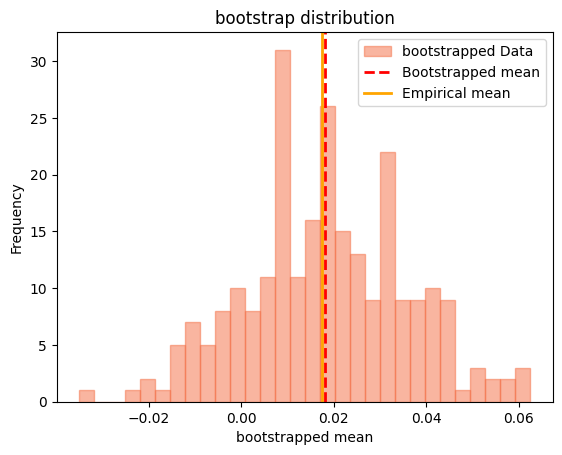

In [ ]:
plt.title("bootstrap distribution")
plt.hist(bootstrap, bins=30, alpha=0.5, color='#f46d43', edgecolor='#f46d43',label='bootstrapped Data')
plt.axvline(bootstrapped_mean, color='r', linestyle='dashed', linewidth=2, label='Bootstrapped mean')
plt.axvline(empirical_mean, color='orange', linestyle='-', linewidth=2, label='Empirical mean')
plt.xlabel("bootstrapped mean")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
def mean_statistic(data):
    return np.mean(data, axis=-1)

1.965912343229391
A 95'%' confidence interval for the mean is : [-0.016903466006514337, 0.05190346600651434]
-------------------------------
A 95'%' percentile boostrap confidence interval for the mean is : [-0.0125, 0.05387500000000003]
Scipy percentile bootstrap: ConfidenceInterval(low=-0.017499999999999995, high=0.052500000000000005)
-------------------------------
A 95'%' basic boostrap confidence interval for the mean is : [-0.018875000000000024, 0.0475]
Scipy basic bootstrap: ConfidenceInterval(low=-0.017499999999999995, high=0.052500000000000005)
-------------------------------
A 95'%' BCA confidence interval for the mean is : [-0.01588644  0.05      ]
A 95'%' BC confidence interval for the mean is : [-0.01636065  0.05      ]
Scipy BCA bootstrap: ConfidenceInterval(low=-0.015, high=0.0525)
-------------------------------
Difference Scipy - Manual for Percentile bootstrap [-0.004999999999999994, -0.001375000000000022]
Difference Scipy - Manual for Basic bootstrap [0.0013750000000

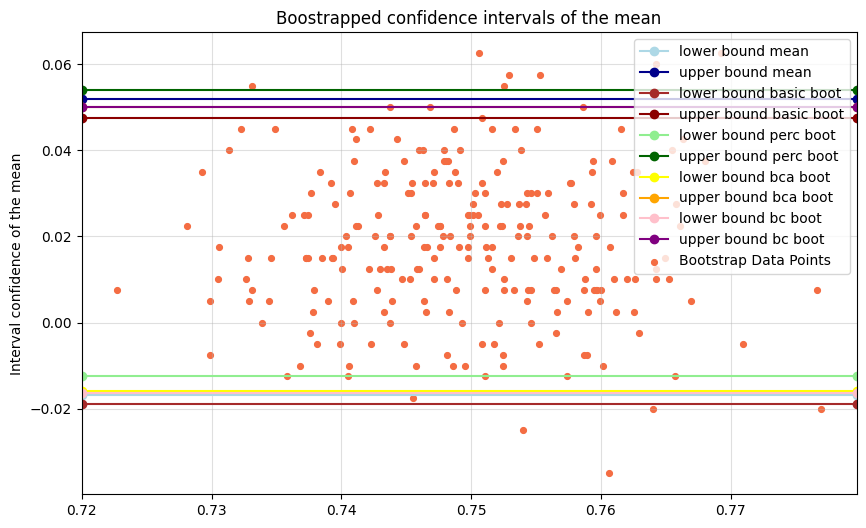

In [ ]:
def confidence_intervals():

    alpha = 0.05 # Confidence level
    n = len(errors)

    t_student = stats.t.ppf(1 - alpha / 2, n)
    print(t_student)
    lower = empirical_mean - t_student * std_error_param # Parametric method with student
    upper = empirical_mean + t_student * std_error_param

    conf_interval = pd.Interval(left=lower, right=upper, closed='both')

    print("A 95'%' confidence parametric interval for the mean is :", conf_interval)

    lower_boot = np.percentile(bootstrap , 100 * (alpha/2))
    upper_boot = np.percentile(bootstrap, 100 * (1 - alpha / 2))

    conf_interval_perc_boot = pd.Interval(left=lower_boot, right=upper_boot, closed='both') # Percentile bootstrap

    print("-------------------------------")

    print("A 95'%' percentile boostrap confidence interval for the mean is :", conf_interval_perc_boot)

    conf_interval_basic_boot = pd.Interval(left=2*empirical_mean-upper_boot, right=2*empirical_mean-lower_boot, closed='both') # basic bootstrap

    print("-------------------------------")

    print("A 95'%' basic boostrap confidence interval for the mean is :", conf_interval_basic_boot)

    # Bias correction
    z0 = stats.norm.ppf(np.mean(bootstrap < empirical_mean))

    z_alpha = norm.ppf(alpha / 2)
    z_1_alpha = norm.ppf(1 - alpha / 2)

    # Acceleration
    jackknife_samples = np.array([np.mean(np.delete(errors, i)) for i in range(len(errors))])
    jackknife_mean = np.mean(jackknife_samples)
    a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)

    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bca_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile]) # BCA bootstrap`

    a = 0 # BC bootstrap

    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bc_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile])

    print("-------------------------------")

    print("A 95'%' BCA confidence interval for the mean is :", conf_interval_bca_boot)
    print("A 95'%' BC confidence interval for the mean is :", conf_interval_bc_boot)

    print("-------------------------------")

    print("Width of the differents intervals :")

    narrowness_student = (conf_interval.right - conf_interval.left)
    narrowness_perc = (conf_interval_perc_boot.right - conf_interval_perc_boot.left)
    narrowness_basic = (conf_interval_basic_boot.right - conf_interval_basic_boot.left)
    narrowness_bca = (conf_interval_bca_boot[1] - conf_interval_bca_boot[0])
    narrowness_bc = (conf_interval_bc_boot[1] - conf_interval_bc_boot[0])

    print("Width of Parametric interval :", narrowness_student)
    print("Width of Percentile boot interval :", narrowness_perc)
    print("Width of Basic boot interval :", narrowness_basic)
    print("Width of BCA boot interval :", narrowness_bca)
    print("Width of BC boot interval :", narrowness_bc)

    print("-------------------------------")

    y1, y2 = extract_bounds(conf_interval)
    y3, y4 = extract_bounds(conf_interval_basic_boot)
    y5, y6 = extract_bounds(conf_interval_perc_boot)
    y7, y8 = conf_interval_bca_boot[0], conf_interval_bca_boot[1]
    y9, y10 = conf_interval_bc_boot[0], conf_interval_bc_boot[1]

    plt.figure(figsize=(10, 6))
    plt.axhline(y1, label='lower bound parametric', marker='o', color="lightblue")
    plt.axhline(y2, label='upper bound parametric', marker='o', color="darkblue")
    plt.axhline(y3, label='lower bound basic boot', marker='o', color="brown")
    plt.axhline(y4, label='upper bound basic boot', marker='o', color="darkred")
    plt.axhline(y5, label='lower bound perc boot', marker='o', color="lightgreen")
    plt.axhline(y6, label='upper bound perc boot', marker='o', color="darkgreen")
    plt.axhline(y7, label='lower bound bca boot', marker='o', color="yellow")
    plt.axhline(y8, label='upper bound bca boot', marker='o', color="orange")
    plt.axhline(y9, label='lower bound bc boot', marker='o', color="pink")
    plt.axhline(y10, label='upper bound bc boot', marker='o', color="purple")


    jittered_x = np.random.normal(loc=0, scale=0.01, size=len(bootstrap))

    plt.scatter(jittered_x, bootstrap, alpha=1, color='#f46d43', edgecolor='#f46d43', s=8, label='Bootstrap Data Points', linewidths=2)
    plt.scatter(0, empirical_mean, color = 'black', s =10, label = "Empirical mean")

    plt.xlabel('')
    plt.ylabel('Interval confidence of the mean')
    plt.title('Boostrapped confidence intervals of the mean')
    plt.legend()
    plt.grid(True, alpha =0.4)
    plt.show()

    return (conf_interval, conf_interval_perc_boot, conf_interval_basic_boot, conf_interval_bca_boot, conf_interval_bc_boot,
   narrowness_student, narrowness_perc, narrowness_basic, narrowness_bca, narrowness_bc )

(conf_interval, conf_interval_perc_boot, conf_interval_basic_boot, conf_interval_bca_boot, conf_interval_bc_boot,
   narrowness_student, narrowness_perc, narrowness_basic, narrowness_bca, narrowness_bc ) = confidence_intervals()


In [ ]:
def plot_evolution_confidence_intervals(list_intervals, subset_sizes, title):
   lower_bounds = [interval.left for interval in list_intervals]
   upper_bounds = [interval.right for interval in list_intervals]

   plt.figure(figsize=(10, 6))
   plt.plot(subset_sizes, lower_bounds, label='Lower Bound', marker='o')
   plt.plot(subset_sizes, upper_bounds, label='Upper Bound', marker='o')
   plt.fill_between(subset_sizes, lower_bounds, upper_bounds, color='b', alpha=0.1)
   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, {title}")
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_evolution_confidence_intervals_array(list_intervals, subset_sizes, title):
   lower_bounds = [interval[0] for interval in list_intervals]
   upper_bounds = [interval[1] for interval in list_intervals]
   k_values = range(1, len(list_intervals) + 1)

   plt.figure(figsize=(10, 6))
   plt.plot(subset_sizes, lower_bounds, label='Lower Bound', marker='o')
   plt.plot(subset_sizes, upper_bounds, label='Upper Bound', marker='o')
   plt.fill_between(subset_sizes, lower_bounds, upper_bounds, color='b', alpha=0.1)
   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, {title}")
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_all_confidence_intervals(list_1, list_2, list_3, list_4, list_5, subset_sizes):

   lower_bound_1 = [interval.left for interval in list_1]
   upper_bound_1 = [interval.right for interval in list_1]

   lower_bound_2 = [interval.left for interval in list_2]
   upper_bound_2 = [interval.right for interval in list_2]

   lower_bound_3 = [interval.left for interval in list_3]
   upper_bound_3 = [interval.right for interval in list_3]

   lower_bound_4 = [interval[0] for interval in list_4]
   upper_bound_4 = [interval[1] for interval in list_4]

   lower_bound_5 = [interval[0] for interval in list_5]
   upper_bound_5 = [interval[1] for interval in list_5]

   plt.figure(figsize=(10, 6))

# Parametric bounds
   plt.plot(subset_sizes, lower_bound_1, label='Lower Bound Parametric', marker='o', color='black', linestyle='-')
   plt.plot(subset_sizes, upper_bound_1, label='Upper Bound Parametric', marker='o', color='black', linestyle='-')

# Basic Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_2, label='Lower Bound Basic Boot', marker='s', color='red', linestyle='--')
   plt.plot(subset_sizes, upper_bound_2, label='Upper Bound Basic Boot', marker='s', color='red', linestyle='--')

# Percentile Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_3, label='Lower Bound Perc Boot', marker='^', color='green', linestyle='-.')
   plt.plot(subset_sizes, upper_bound_3, label='Upper Bound Perc Boot', marker='^', color='green', linestyle='-.')

# BCa Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_4, label='Lower Bound BCA Boot', marker='D', color='blue', linestyle=':')
   plt.plot(subset_sizes, upper_bound_4, label='Upper Bound BCA Boot', marker='D', color='blue', linestyle=':')

# BC Bootstrap bounds
   plt.plot(subset_sizes, lower_bound_5, label='Lower Bound BC Boot', marker='v', color='purple', linestyle=(0, (3, 5, 1, 5)))
   plt.plot(subset_sizes, upper_bound_5, label='Upper Bound BC Boot', marker='v', color='purple', linestyle=(0, (3, 5, 1, 5)))

   plt.fill_between(subset_sizes, lower_bound_1, upper_bound_1, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_2, upper_bound_2, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_3, upper_bound_3, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_4, upper_bound_4, color='b', alpha=0.1)
   plt.fill_between(subset_sizes, lower_bound_5, upper_bound_5, color='b', alpha=0.1)

   plt.xlabel('subset_sizes')
   plt.ylabel('Confidence Interval')
   plt.title(f"Evolution of Confidence Intervals, different methods")
   plt.legend()
   plt.grid(True)
   plt.show()


def averaged_confidence_intervals(k, empirical_mean, num_samples=1000): # k number of progressive subsets you want, num_samples nb of simulation per subset

      alpha = 0.05 # Confidence level
      n = len(errors)

      t_student = stats.t.ppf(1 - alpha / 2, n)

      standard_errors_list_avg = []
      list_classic_intervals_avg = []
      list_classic_boot_intervals_avg = []
      list_percentile_boot_intervals_avg = []
      list_bca_boot_intervals_avg = []
      list_bc_boot_intervals_avg = []

      list_classic_coverage = []
      list_classic_boot_coverage = []
      list_percentile_boot_coverage = []
      list_bca_boot_coverage = []
      list_bc_boot_coverage = []

      n = len(errors)
      subset_sizes_avg = np.linspace(n // k, n, k, dtype=int)

      for size in subset_sizes_avg:

          sem_samples = []
          classic_intervals_samples = []
          classic_boot_intervals_samples = []
          percentile_boot_intervals_samples = []
          bca_boot_intervals_samples = []
          bc_boot_intervals_samples = []

          for _ in range(num_samples):

              data_subset = np.random.choice(errors, size=size, replace=False)

              mean_subset = np.mean(data_subset)
              sem = np.std(data_subset)/np.sqrt(size)

              sem_samples.append(sem)

              B = 250 # Bootstrap estimate
              bootstrap_indices_subset = np.random.choice(len(data_subset), size=(B, len(data_subset)), replace=True)

              bootstrap_subset = []
              for indices in bootstrap_indices_subset:
                  boot_mean_subset = np.mean(data_subset[indices])
                  bootstrap_subset.append(boot_mean_subset)

              bootstrapped_mean_subset = np.mean(bootstrap_subset)
              bootstrapped_std_error_subset = np.std(bootstrap_subset)

              lower = mean_subset - t_student * sem # Parametric method
              upper = mean_subset + t_student * sem
              classic_intervals_samples.append((lower, upper))

              lower_boot = np.percentile(bootstrap_subset , 100 * (alpha/2))
              upper_boot = np.percentile(bootstrap_subset, 100 * (1 - alpha / 2))
              percentile_boot_intervals_samples.append((lower_boot, upper_boot)) # Percentile bootstrap
              classic_boot_intervals_samples.append((2*mean_subset-upper_boot, 2*mean_subset-lower_boot)) # basic bootstrap

              # Acceleration
              jackknife_samples_subset = np.array([np.mean(np.delete(data_subset, i)) for i in range(len(data_subset))])
              jackknife_mean_subset = np.mean(jackknife_samples_subset)
              a_subset = np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 3) / (6 * np.sum((jackknife_mean_subset - jackknife_samples_subset) ** 2) ** 1.5)

              # Bias correction
              z0_subset = stats.norm.ppf(np.mean(bootstrap_subset < mean_subset))
              z_alpha_subset = norm.ppf(alpha / 2)
              z_1_alpha_subset = norm.ppf(1 - alpha / 2)

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bca_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BCA bootstrap
              bca_boot_intervals_samples.append(bca_boot_interval)

              a_subset = 0

              lower_percentile = norm.cdf(z0_subset + (z0_subset + z_alpha_subset) / (1 - a_subset * (z0_subset + z_alpha_subset))) * 100
              upper_percentile = norm.cdf(z0_subset + (z0_subset + z_1_alpha_subset) / (1 - a_subset * (z0_subset + z_1_alpha_subset))) * 100

              bc_boot_interval = np.percentile(bootstrap_subset, [lower_percentile, upper_percentile]) # BC bootstrap
              bc_boot_intervals_samples.append(bc_boot_interval)


          standard_errors_list_avg.append(np.mean(sem_samples))
          list_classic_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in classic_intervals_samples]), right=np.mean([i[1] for i in classic_intervals_samples]), closed='both'))
          list_classic_boot_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in classic_boot_intervals_samples]), right=np.mean([i[1] for i in classic_boot_intervals_samples]), closed='both'))
          list_percentile_boot_intervals_avg.append(pd.Interval(left=np.mean([i[0] for i in percentile_boot_intervals_samples]), right=np.mean([i[1] for i in percentile_boot_intervals_samples]), closed='both'))
          list_bca_boot_intervals_avg.append(np.mean(bca_boot_intervals_samples, axis=0))
          list_bc_boot_intervals_avg.append(np.mean(bc_boot_intervals_samples, axis=0))

      return subset_sizes_avg, standard_errors_list_avg, list_classic_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg,



subset_sizes_avg, standard_errors_list_avg, list_parametric_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg = averaged_confidence_intervals(10, 1000)

plot_all_confidence_intervals(list_parametric_intervals_avg, list_classic_boot_intervals_avg, list_percentile_boot_intervals_avg, list_bca_boot_intervals_avg, list_bc_boot_intervals_avg, subset_sizes_avg)


# II - Statistical testing

## II.1 - Parametric, permutation and bootstrap testing

Null hypothesis $H_0$ and its alternative $H_1$ are defined as followed :
\begin{align*}
H_0 &: \mu_A = \mu_B \\
H_1 &: \mu_A \neq \mu_B
\end{align*}

The test statistic can be written as followed :
$$
T = \frac{μ_D}{SE(m_D)}
$$
Where $μ_D$ and $m_D$ represent the real mean of $D = A - B$ and its empirical counterpart, and $SE(m_D)$ is the standard error of the mean of the difference.

If the p value is under 0.05, we reject the null hypothesis, and thus we can affirm that the two models don't have the same performance.

This is a paired test

In [ ]:
def statistical_testing():

    alpha = 0.05
    num_permutations = 1000
    supposed_mu = 0 # to change (here, equality of performance)

    t_stat, p_value = ttest_rel(errors_1, errors_2)
    print("The scipy t_stat is :", t_stat)
    print("The scipy p-value is :", p_value)

    test_stat = (empirical_mean-supposed_mu)/std_error_param # Bilateral test.
    student = stats.t.ppf(1-alpha/2, df=len(errors)-1)

    print("student:", student)
    print("Hand made t-stat:", test_stat)

    p_value = 2*(1 - stats.t.cdf(abs(test_stat), df=len(errors)-1))
    puissance = 1 - stats.norm.cdf(student - test_stat, 0, 1)

    print("The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :")
    print("The hand made p-value of the bilateral test is :", p_value)
    print("The hand made power of the bilateral test is :", puissance)

    # With bootstrapped values

    test_stat_boot = (bootstrapped_mean-supposed_mu)/bootstrapped_std_error

    print("t-stat boot:", test_stat_boot)

    p_value_boot = 2*(1 - stats.t.cdf(abs(test_stat_boot), df=len(errors)-1))
    puissance_boot = 1 - stats.norm.cdf(student - test_stat_boot, 0, 1)

    print("The bootstrapped p-value of the bilateral test is :", p_value_boot)
    print("The bootstrapped power of the bilateral test is :", puissance_boot)

    return p_value, p_value_boot, puissance, puissance_boot

p_value, p_value_boot, puissance, puissance_boot = statistical_testing()


The scipy t_stat is : 1.0000000000000002
The scipy p-value is : 0.3179165706461152
student: 1.965927295920809
Hand made t-stat: 1.0000000000000002
The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :
The hand made p-value of the bilateral test is : 0.3179165706461151
The hand made power of the bilateral test is : 0.16704028131949777
t-stat boot: 1.04135151169445
The bootstrapped p-value of the bilateral test is : 0.29834300537749714
The bootstrapped power of the bilateral test is : 0.17759330705984644


## II.2 Non parametric testing - Wilcoxon signed rank

The Wilcoxon Signed-Rank Test is a non-parametric statistical test used to compare two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ. It is often used as an alternative to the paired t-test when the data cannot be assumed to be normally distributed.

$W^+$ is the sum of the ranks for the positive differences.
$W^-$is the sum of the ranks for the negative differences.
The test statistic $W$ is the smaller of $W^+$ and $W^-$

In [ ]:
def statistical_testing_wilcoxon():

    alpha = 0.05
    supposed_mu = 0

    # Wilcoxon signed-rank test
    wilcoxon_result = stats.wilcoxon(errors - supposed_mu)
    p_value_wil = wilcoxon_result.pvalue

    print("The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable:")
    print("The p-value of the Wilcoxon signed-rank test is:", p_value_wil)

    return p_value_wil

p_value_wil = statistical_testing_wilcoxon()

The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable:
The p-value of the Wilcoxon signed-rank test is: 0.31731050786291415


## II.3 - McNemar Chi Squared test

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

def test_mcnemar():

  a = np.sum((errors_file_1['Error'] == 0) & (errors_file_2['Error'] == 0))
  b = np.sum((errors_file_1['Error'] == 0) & (errors_file_2['Error'] == 1))
  c = np.sum((errors_file_1['Error'] == 1) & (errors_file_2['Error'] == 0))
  d = np.sum((errors_file_1['Error'] == 1) & (errors_file_2['Error'] == 1))

  table = np.array([[a, b],
                  [c, d]])
  print(f'Table de contingence:\n{table}')

  result = mcnemar(table, exact=False, correction=True)

  print(f'Statistique de test: {result.statistic}')
  print(f'p-value: {result.pvalue}')

  return result.statistic, result.pvalue

stat_class, pvalue_class = test_mcnemar()

Table de contingence:
[[ 25  21]
 [ 28 326]]
Statistique de test: 0.7346938775510204
p-value: 0.39136593830755195


# Saving data

In [ ]:
def save_data():
    data = {
    "Empirical mean": empirical_mean,
    "Empirical standard deviation": empirical_std_deviation,
    "Empirical first quartile": q1,
    "Empirical median": med,
    "Empirical third quartile": q3,
    "Bootstrapped empirical mean": bootstrapped_mean,
    "Empirical standard error": bootstrapped_std_error,
    "Bootstrapped empirical standard error": std_error_param,
    "95% confidence interval for the mean": str(conf_interval),
    "95% percentile bootstrap confidence interval for the mean": str(conf_interval_perc_boot),
    "95% basic bootstrap confidence interval for the mean": str(conf_interval_basic_boot),
    "95% accelerated bootstrap confidence interval for the mean": str(conf_interval_bca_boot),
    "Normalized width of studentized interval": narrowness_student,
    "Normalized width of basic bootstrapped interval ": narrowness_basic,
    "Normalized width of percentile bootstrapped interval ": narrowness_perc,
    "Normalized width of BCA bootstrapped interval ": narrowness_bca,
    "The p-value of the bilateral test is ": p_value,
    "The power of the bilateral test is ": puissance,
    "The bootstrapped p-value of the bilateral test is ": p_value_boot,
    "The boostrapped power of the bilateral test is ": puissance_boot,
    "The p-value of the Wilcoxon signed-rank test is": p_value_wil,
    "The p-value of the McNemar chi-squared test is": pvalue_class,


}


    json_file_path = f"statistics_comparison_{model}_{metric}_{additional}_summary.json" # a modifier
    with open(json_file_path, 'w') as json_file:
       json.dump(data, json_file, indent=4)

    print(f"Data have been saved in the file {json_file_path}")

save_data()


Data have been saved in the file statistics_comparison_XGB_vs_DecisionTree_onezero_vs_onezero_SK_30_SK_30_summary.json
Files have been saved in Google Drive at :
/content/drive/My Drive/work/Summary/statistics_comparison_XGB_vs_DecisionTree_onezero_vs_onezero_SK_30_SK_30_summary.json
